## Pricing Test



### Goal

Pricing optimization is, non surprisingly, another area where data science can provide huge value.

The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.


### Challenge Description


Company XYZ sells a software for 39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price ( 39 ), while a random sample of 33% users a higher price (59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially, you were asked the following questions:

The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. [**What are your main findings looking at the data?**](#q1)

[**Should the company sell its software for 39 or 59?**](#q2)

[Bonus] [**The VP of Product feels that the test has been running for too long and they should have been able to get statistically significant results in a shorter time. Do you agree with this? After how many days you would have stopped the test?**](#q3) Please, explain why.

#### Data Table 1: Test Results
Columns:
- user_id : the Id of the user. Can be joined to user_id in user_table
- timestamp : the date and time when the user hit for the first time company XYZ webpage. It is in user local time
- source : marketing channel that led to the user coming to the site. It can be: 
- ads-[“google”, “facebook”, “bing”, “yahoo”, “other”]. That is, user coming from google ads, yahoo ads, etc.
- seo - [“google”, “facebook”, “bing”, “yahoo”, “other”]. That is, user coming from google search, yahoo, facebook, etc.
- friend_referral : user coming from a referral link of another user
- direct_traffic: user coming by directly typing the address of the site on the browser
- device : user device. Can be mobile or web.
- operative_system : user operative system. Can be: “windows”, “linux”, “mac” for web, and “android”, “iOS” for mobile. "Other" if it is none of the above
- test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old/lower price)
- price : the price the user sees. It should match test
- converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df1 = pd.read_csv("Pricing_Test/test_results.csv")

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [4]:
#check all user ids are unique
df1.user_id.nunique()

316800

#### Data Table 2: User Table
Columns:
- user_id : the Id of the user. Can be joined to user_id in test_results table
- city : the city where the user is located. Comes from the user ip address
- country : in which country the city is located
- lat : city latitude - should match user city
- long : city longitude - should match user city

In [5]:
df2 = pd.read_csv("Pricing_Test/user_table.csv")

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


#### Data Processing

In [7]:
df = pd.merge(df1,df2, how = 'left', on = ['user_id'] )

In [8]:
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [9]:
#In order to convert to timestamp object, minute must be within 0 to 59...
df[df['timestamp'] =='2015-04-24 12:60:46']

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
54,370914,2015-04-24 12:60:46,direct_traffic,mobile,android,0,39,0,North Charleston,USA,32.91,-80.04
77104,493696,2015-04-24 12:60:46,direct_traffic,mobile,android,0,39,0,North Charleston,USA,32.91,-80.04
98348,450970,2015-04-24 12:60:46,direct_traffic,mobile,android,0,39,0,North Charleston,USA,32.91,-80.04
182288,283342,2015-04-24 12:60:46,direct_traffic,mobile,android,0,39,0,NaN,NaN,NaN,NaN
192065,472694,2015-04-24 12:60:46,direct_traffic,mobile,android,0,39,0,North Charleston,USA,32.91,-80.04


In [10]:
#take only date from timestamp column
df['timestamp'] = df['timestamp'].apply(lambda x: x.split()[0])

In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

#### Data Validation

In [12]:
df.groupby(['test','price']).size()

test  price
0     39       202517
      59          210
1     39          155
      59       113918
dtype: int64

According to data description, test= 1 means higher price and 0 means control population, but there are misclassification. To fix, we should assign 210 with price 59 as test = 1 and 155 with price 39 as test = 0.

In [13]:
df.loc[df[(df['test']==0)&(df['price']==59)].index, 'test'] = 1

In [14]:
df.loc[df[(df['test']==1)&(df['price']==39)].index, 'test'] = 0

In [15]:
df.groupby(['test','price']).size()

test  price
0     39       202672
1     59       114128
dtype: int64

### <a id='q1'>What are your main findings looking at the data?<a/>

#### timestamp

In [16]:
#Easier for grouping, extract only year and month
df['year_month'] = pd.to_datetime(df['timestamp']).dt.to_period('M')

In [17]:
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,year_month
0,604839,2015-05-08,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,2015-05
1,624057,2015-05-10,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,2015-05
2,317970,2015-04-04,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,2015-04
3,685636,2015-05-07,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,2015-05
4,820854,2015-05-24,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,2015-05


In [18]:
def groupby(factor):
    #test vs experiment
    con_df = df[(df['test']==0)]
    exp_df = df[(df['test']==1)]

    #Control group 
    con_grouped = con_df.groupby([factor])['converted'].value_counts(normalize=True).\
                                rename('percentage').mul(100).reset_index()
    con_grouped = con_grouped[con_grouped['converted']==1]
    con_grouped['group'] = 'Control'
    #Experiment group 
    exp_grouped = exp_df.groupby([factor])['converted'].value_counts(normalize=True).\
                                rename('percentage').mul(100).reset_index()
    exp_grouped = exp_grouped[exp_grouped['converted']==1]
    exp_grouped['group'] = 'Experiment'
    
    #concat
    coverted_df = pd.concat([con_grouped,exp_grouped], axis = 0)
    return coverted_df

In [19]:
coverted_time = groupby("year_month")

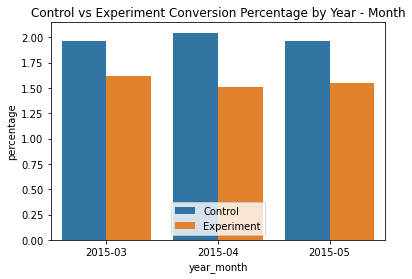

In [20]:
fig, ax = plt.subplots()
ax = sns.barplot(data = coverted_time, x = 'year_month', y = 'percentage', hue = "group");
ax.legend(loc = 'lower center');
plt.title("Control vs Experiment Conversion Percentage by Year - Month");

Control group always have better conversion rate compared to experiment group which makes sense, since it is cheaper

In [21]:
#check split between control vs experiment group
df.groupby("test")['year_month'].value_counts(normalize = True).unstack()

year_month,2015-03,2015-04,2015-05
test,,,
0,0.317266,0.323799,0.358935
1,0.319483,0.319229,0.361287


#### Source

In [22]:
coverted_source = groupby("source")

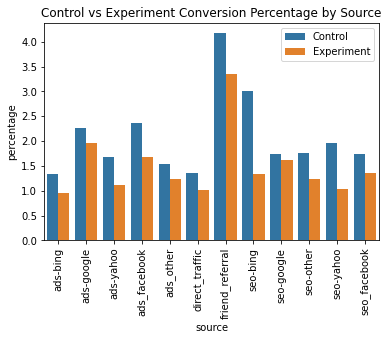

In [23]:
fig, ax = plt.subplots()
ax = sns.barplot(data = coverted_source, x = 'source', y = 'percentage', hue = "group");
ax.legend(loc = 'upper right');
plt.xticks(rotation = 90);
plt.title("Control vs Experiment Conversion Percentage by Source");

In [24]:
#check split between control vs experiment group
df.groupby("test")['source'].value_counts(normalize = True).unstack()

source,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.072043,0.186819,0.023772,0.168203,0.095119,0.191196,0.064755,0.006577,0.074510,0.029037,0.021493,0.066477
1,0.072480,0.188525,0.024227,0.169161,0.092861,0.189323,0.066338,0.007185,0.070745,0.029572,0.021835,0.067748


#### Device

In [25]:
coverted_device = groupby("device")

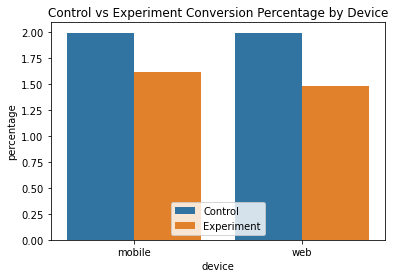

In [26]:
fig, ax = plt.subplots()
ax = sns.barplot(data = coverted_device, x = 'device', y = 'percentage', hue = "group");
ax.legend(loc = 'lower center');
plt.title("Control vs Experiment Conversion Percentage by Device");

In [27]:
#check split between control vs experiment group
df.groupby("test")['device'].value_counts(normalize = True).unstack()

device,mobile,web
test,,
0,0.594364,0.405636
1,0.578386,0.421614


#### Operative System

In [28]:
coverted_sys = groupby("operative_system")

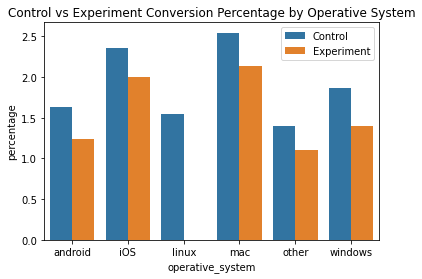

In [29]:
fig, ax = plt.subplots()
ax = sns.barplot(data = coverted_sys, x = 'operative_system', y = 'percentage',
                 hue = "group");
ax.legend(loc = 'upper right');
plt.title("Control vs Experiment Conversion Percentage by Operative System");

In [30]:
df[df['operative_system']=='linux'][['test','converted']].value_counts()

test  converted
0     0            2172
1     0            1929
0     1              34
dtype: int64

There is a big discrepancy within Linux operative system. Within control group, only 34 out of 2207(2173+34) got coverted, and none of experiment group (1928), there might be flaws in the design on Linux system, further investigation is needed.

In [31]:
#check split between control vs experiment group
df.groupby("test")['operative_system'].value_counts(normalize = True).unstack()

operative_system,android,iOS,linux,mac,other,windows
test,,,,,,
0,0.237867,0.305138,0.010885,0.080692,0.051763,0.313655
1,0.234176,0.294599,0.016902,0.076502,0.050058,0.327764


In addition, especially the spilt for Linux doesn't follow 66%/33% split as claimed.

#### Country

In [32]:
coverted_cty = groupby("country")

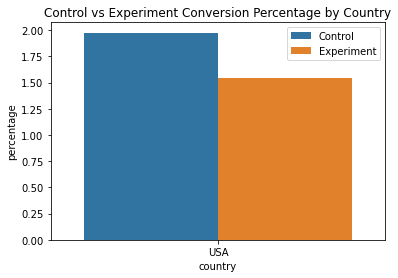

In [33]:
fig, ax = plt.subplots()
ax = sns.barplot(data = coverted_cty, x = 'country', y = 'percentage',
                 hue = "group");
ax.legend(loc = 'upper right');
plt.title("Control vs Experiment Conversion Percentage by Country");

In [34]:
#check split between control vs experiment group
df.groupby("test")['country'].value_counts(normalize = True).unstack()

country,USA
test,
0,1.0
1,1.0


#### City

In [36]:
#test vs experiment
con_df = df[(df['test']==0)]
exp_df = df[(df['test']==1)]

#Control group 
con_grouped = con_df.groupby(['city'])['converted'].value_counts(normalize=True).\
                            rename('percentage').mul(100).reset_index()
con_grouped = con_grouped[con_grouped['converted']==1]
con_grouped['group'] = 'Control'
#Experiment group 
exp_grouped = exp_df.groupby(['city'])['converted'].value_counts(normalize=True).\
                            rename('percentage').mul(100).reset_index()
exp_grouped = exp_grouped[exp_grouped['converted']==1]
exp_grouped['group'] = 'Experiment'

#concat
coverted_df = pd.concat([con_grouped,exp_grouped], axis = 0)

In [37]:
#average city has ~298 users
df.groupby('city').size().values.mean()

298.6088840736728

In [38]:
dense_city = df.groupby('city').size().rename("count").reset_index()
dense_city = dense_city[dense_city['count']>=300]

In [39]:
#get common cities in both control and experiment group
con_city = set(con_grouped['city'])
exp_city = set(exp_grouped['city'])
den_city = set(dense_city['city'])
common_city = set.intersection(con_city,exp_city,den_city)

# coverted_df_tot = coverted_df.copy()
coverted_df = coverted_df[coverted_df['city'].isin(common_city)]

In [40]:
len(common_city)

198

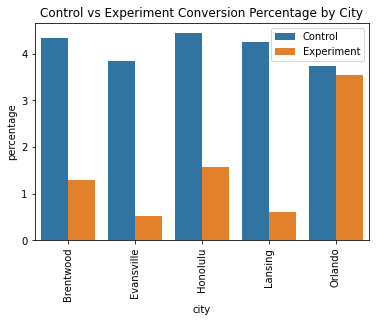

In [41]:
#top 5 from control group
top5_control = coverted_df[coverted_df['group']=='Control']\
                .sort_values('percentage', ascending= False)['city'][:5].values

temp = coverted_df[coverted_df['city'].isin(top5_control)]
fig, ax = plt.subplots()
ax = sns.barplot(data = temp, x = 'city', y = 'percentage',
                 hue = "group");
ax.legend(loc = 'upper right');
plt.xticks(rotation = 90);
plt.title("Control vs Experiment Conversion Percentage by City");

In [42]:
df[df['city'].isin(top5_control)].groupby('test')['city'].value_counts().unstack()

city,Brentwood,Evansville,Honolulu,Lansing,Orlando
test,,,,,
0,231,234,225,306,268
1,154,191,127,167,141


Brentwood is in CA, Evansville is in Indiana, Honolulu is in Hawaii, Lansing is in Michigan, Orlando is in Florida

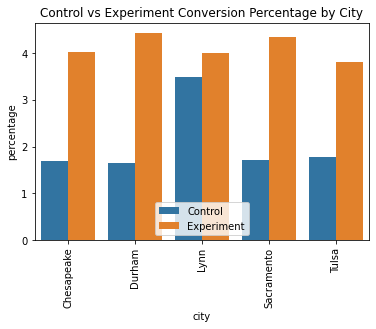

In [43]:
#top 5 from experiment group
top5_exp = coverted_df[coverted_df['group']=='Experiment']\
                .sort_values('percentage', ascending= False)['city'][:5].values
temp1 = coverted_df[coverted_df['city'].isin(top5_exp)]
fig, ax = plt.subplots()
ax = sns.barplot(data = temp1, x = 'city', y = 'percentage',
                 hue = "group");
ax.legend(loc = 'lower center');
plt.xticks(rotation = 90);
plt.title("Control vs Experiment Conversion Percentage by City");

In [44]:
df[df['city'].isin(top5_exp)].groupby('test')['city'].value_counts().unstack()

city,Chesapeake,Durham,Lynn,Sacramento,Tulsa
test,,,,,
0,177,244,229,235,396
1,124,158,100,138,184


Chesapeake is in Virginia, Durham is in North Carolina, Lynn is in Massachusetts, Sacramento is in California, and Tulsa is in Oklahoma

In [45]:
#from df2 get city location data only and remove duplicates
location = df2[['city','lat','long']].copy()
location.drop_duplicates(inplace = True)
#merge with coverted_city
merged_coverted_city = pd.merge(coverted_df,location, how = 'left', on ='city')

In [46]:
#top 10 from control group
top10_control = merged_coverted_city[merged_coverted_city['group']=='Control']\
                .sort_values('percentage', ascending= False)['city'][:10].values
location[location['city'].isin(top10_control)].mean()

lat     35.913
long   -98.838
dtype: float64

In [47]:
#top 10 from experiment group
top10_exp = merged_coverted_city[merged_coverted_city['group']=='Experiment']\
                .sort_values('percentage', ascending= False)['city'][:10].values
location[location['city'].isin(top10_exp)].mean()

lat     33.919
long   -88.732
dtype: float64

Accoring to definition, positive latitude is above the equator (N), and negative latitude is below the equator (S), and positive longitude is east of the prime meridian, while negative longitude is west of the prime meridian (a north-south line that runs through a point in England). Looking at major cities from the control group come from western part of U.S, and on the other hand, cities from the experiment group come from eastern side.

### <a id='q2'> Should the company sell its software for 39 or 59?<a/>

In [48]:
df['revenue'] = df['converted'] * df['price']

In [49]:
df[['test', 'converted','revenue']].groupby('test').\
                agg({'converted':'mean','revenue':'mean' })

,converted,revenue
test,,
0,0.019889,0.775682
1,0.015570,0.918644


$H_0:$experiment group's average conversion **is equal or less than** control group     
$H_1:$experiment group's average conversion **is greater than** control group

In [50]:
t_test = stats.ttest_ind(df[df['test'] == 1]['converted'], 
                         df[df['test'] == 0]['converted'], 
                         equal_var=False)

In [51]:
print(t_test.statistic, t_test.pvalue/2)

-8.996272304108324 1.1750918867071857e-19


For inequality of means, it is a one-sided test, thus need to divide the p-value by 2. Let's assume alpha = 0.05, since p value is smaller than 0.05, we reject the null hypothesis and accept the althernative hypothesis.

$H_0:$experiment group's average revenue **is equal or less than** control group     
$H_1:$experiment group's average revenue **is greater than** control group

In [52]:
t_test_r = stats.ttest_ind(df[df['test'] == 1]['revenue'], 
                         df[df['test'] == 0]['revenue'], 
                         equal_var=False)

In [53]:
print(t_test_r.statistic, t_test_r.pvalue/2)

5.770369440939589 3.961128864730514e-09


The same conclusion to reject the null and accept the alternative hypothesis

**Although t test suggests the company would be better off by selling at 59, the results are not 100% reliable,** 
because price isn't the only difference among all factors. For example, the split for Linux operating system isn't 66/33 split which could potentially impact test results. I would suggest further testing to ensure accurate results, and for now, no conclusions can be drawn.

### <a id='q3'>The VP of Product feels that the test has been running for too long and they should have been able to get statistically significant results in a shorter time. Do you agree with this? After how many days you would have stopped the test?<a/>

According to the above observations, although price plays a curical role, other factors, such as source (friend referal), operative system(mac and iOS) may also impact results.

For duration of the test, it would be the best to run for couple business cycles, especially during the conversion rate graph below, the conversion rate fluctuates, and there is a clear pattern that more users are active during weekends.

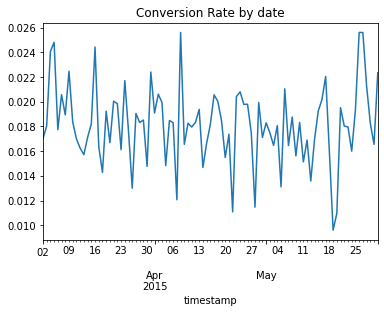

In [54]:
df.groupby('timestamp')['converted'].mean().plot();
plt.title("Conversion Rate by date");

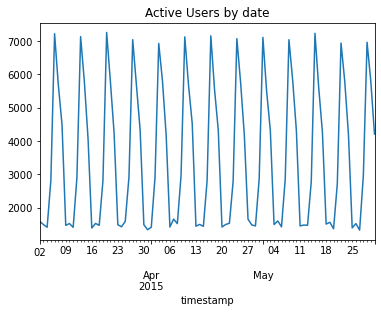

In [55]:
df.groupby('timestamp').size().plot();
plt.title("Active Users by date");

In [56]:
df.groupby('timestamp').size().head(14)

timestamp
2015-03-02    1589
2015-03-03    1496
2015-03-04    1413
2015-03-05    2821
2015-03-06    7214
2015-03-07    5688
2015-03-08    4489
2015-03-09    1469
2015-03-10    1525
2015-03-11    1412
2015-03-12    2895
2015-03-13    7128
2015-03-14    5786
2015-03-15    4067
dtype: int64